In [1]:
import torch
import tables
import os
import sys
import glob
import PIL
import numpy as np
import scipy.io
import cv2
import matplotlib
import matplotlib.pyplot as plt
import sklearn.feature_extraction.image
import random
from sklearn.model_selection import train_test_split

In [2]:
test_masks = sorted(glob.glob('/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/Labels/*.mat'))
test_imgs = sorted(glob.glob('/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/test/Images/*.tif'))
train_masks = sorted(glob.glob('/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/*.mat'))
train_imgs = sorted(glob.glob('/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/*.png'))
print("number of test mask files: ", len(test_masks))
print("number of test image files: ", len(test_imgs))
print("number of train image files: ", len(train_imgs))
print("number of train mask files: ", len(train_masks))

number of test mask files:  14
number of test image files:  14
number of train image files:  30
number of train mask files:  30


In [3]:
patch_size = 224
stride_size = patch_size//2
mirror_pad_size =  patch_size//2
resize=1
classes=[0, 1]
img_types=["img", "mask"]
block_shape = {}
block_shape['img'] = np.array((patch_size, patch_size, 3))
block_shape['mask'] = np.array((patch_size, patch_size))
img_dtype = tables.UInt8Atom()
filenameAtom = tables.StringAtom(itemsize=255)
filters = tables.Filters(complevel=6, complib='zlib')

In [4]:
train_masks

['/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-18-5592-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-21-5784-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-21-5786-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-38-6178-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-49-4488-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-50-5931-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentati

In [5]:
train_imgs

['/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-18-5592-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-21-5784-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-21-5786-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-38-6178-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-49-4488-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-50-5931-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucl

In [6]:
# Do train/test split for the test set
indices = np.arange(len(train_imgs))
train_indices, valid_indices = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)
print(train_indices)
print(valid_indices)

[28 24 12  0  4 16  5 13 11 22  1  2 25  3 21 26 18 29 20  7 10 14 19  6]
[27 15 23 17  8  9]


In [7]:
np_train_imgs = np.array(train_imgs)
np_train_masks = np.array(train_masks)

In [8]:
train_imgs2 = np_train_imgs[train_indices].tolist()
train_masks2 = np_train_masks[train_indices].tolist()
train_imgs2

['/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-NH-A8F7-01A-01-TS1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-HE-7128-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-B0-5710-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-18-5592-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-49-4488-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Images/TCGA-E2-A14V-01Z-00-DX1.png',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucl

In [9]:
valid_imgs = np_train_imgs[valid_indices].tolist()
valid_masks = np_train_masks[valid_indices].tolist()
valid_masks

['/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-KB-A93J-01A-01-TS1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-DK-A2I6-01A-01-TS1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-G9-6363-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-E2-A1B5-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-AR-A1AK-01Z-00-DX1_mask.mat',
 '/home/leos/IMAGE_ANALYSIS/datasets/H&E/nuclei_segmentation/exhaustive_annotations/Nucleisegmentation-Kumar/train/Labels/TCGA-AR-A1AS-01Z-00-DX1_mask.mat']

# Create the HDF5 database

In [10]:
storage = {}
# phases = ['train', 'valid', 'test']
phases = ['train', 'test']

for phase in phases:
    
    # store classes counts to 2x2 matrix (for both val and test)
    totals = np.zeros((2, len(classes)))
    totals[0,:] = classes

    # OPEN A HDF5 FILE WHERE WE WILL WRITE 
    # SEPARATELY TRAIN AND TEST HDF5-STRUCTURES    
    hdf5 = tables.open_file("/home/leos/IMAGE_ANALYSIS/HDF5_data/databases/Kumar/patch_224/{}_Kumar.pytable".format(phase), mode='w')

    # CREATE AN EMPTY HDF5 ARRAY (EARRAY) FOR 
    # THE FILENAME AND PUT IT TO STORAGE DICT
    storage["filename"] = hdf5.create_earray(
        hdf5.root, 
        'filename', 
        filenameAtom,
        (0,)
    )
    
    # FOR EACH OF THE IMG TYPES (IMG, MASK) CREATE 
    # AN EMPTY EARRAY AND PUT THEM TO STORAGE DICT
    for img_type in img_types:
        storage[img_type] = hdf5.create_earray(
            hdf5.root, 
            img_type, 
            img_dtype,  
            shape=np.append([0], block_shape[img_type]), 
            chunkshape=np.append([1], block_shape[img_type]),
            filters=filters
        )
    
    if phase == 'train':
        data = [train_imgs, train_masks]
    elif phase == 'test':
        data = [test_imgs, test_masks]
    elif phase == 'valid':
        data = [valid_imgs, valid_masks]
    
    for files in data:
        for i, file in enumerate(files):

            if any(file in sublist for sublist in [train_imgs, valid_imgs, test_imgs]):
                img_type = 'img'
            elif any(file in sublist for sublist in [train_masks, valid_masks, test_masks]):
                img_type = 'mask'

            print(img_type)
            
            if img_type == 'img':
                im = cv2.imread(file)
                io = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

            elif img_type == 'mask':
                io = scipy.io.loadmat(file)
                io = io['inst_map']
        
                io = io[..., None].repeat(3, axis=2)

                # Get the number of pixels in the mask
                for j, key in enumerate(classes): 
                    totals[1, j]+=sum(sum(io[:,:,0]==key))
                    
                # totals[1, 1] += cv2.countNonZero(io)
                # totals[1, 0] += io.shape[0]*io.shape[1] - cv2.countNonZero(io[..., 0]) 

            # ADD PADDING TO THE BORDER OF THE IMAGE 
            io = np.pad(
                io,
                [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], 
                mode="reflect"
            )

            # convert input image into overlapping tiles
            # size is ntile_row x ntile_col x 1 x patch_size x patch_size x 3
            io_arr_out = sklearn.feature_extraction.image.extract_patches(
                io,
                (patch_size, patch_size, 3),
                stride_size
            )

            # resize it into a ntile_total x patch_size x patch_size x 3
            io_arr_out = io_arr_out.reshape(-1, patch_size, patch_size, 3)
            
            # save the 4D tensor to the table
            if img_type == 'img':
                storage[img_type].append(io_arr_out)
            elif img_type == 'mask':
                #only need 1 channel for mask data
                storage[img_type].append(io_arr_out[:,:,:,0].squeeze())

            # add the filename to the storage array
            storage["filename"].append([file for x in range(io_arr_out.shape[0])])
            
    # lastly, we should store the number of pixels to a carray
    npixels=hdf5.create_carray(
        hdf5.root, 
        'numpixels', 
        tables.Atom.from_dtype(totals.dtype), 
        totals.shape
    )
    print(totals)
    npixels[:]=totals
    hdf5.close()

img


/home/leos/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function extract_patches is deprecated; The function feature_extraction.image.extract_patches has been deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(msg, category=FutureWarning)


img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
img
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
[[0.0000000e+00 1.0000000e+00]
 [2.1267021e+07 1.2820000e+04]]
img
img
img
img
img
img
img
img
img
img
img
img
img
img
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
mask
[[0.0000000e+00 1.0000000e+00]
 [1.0964513e+07 7.7140000e+03]]


# Check that the database images are good

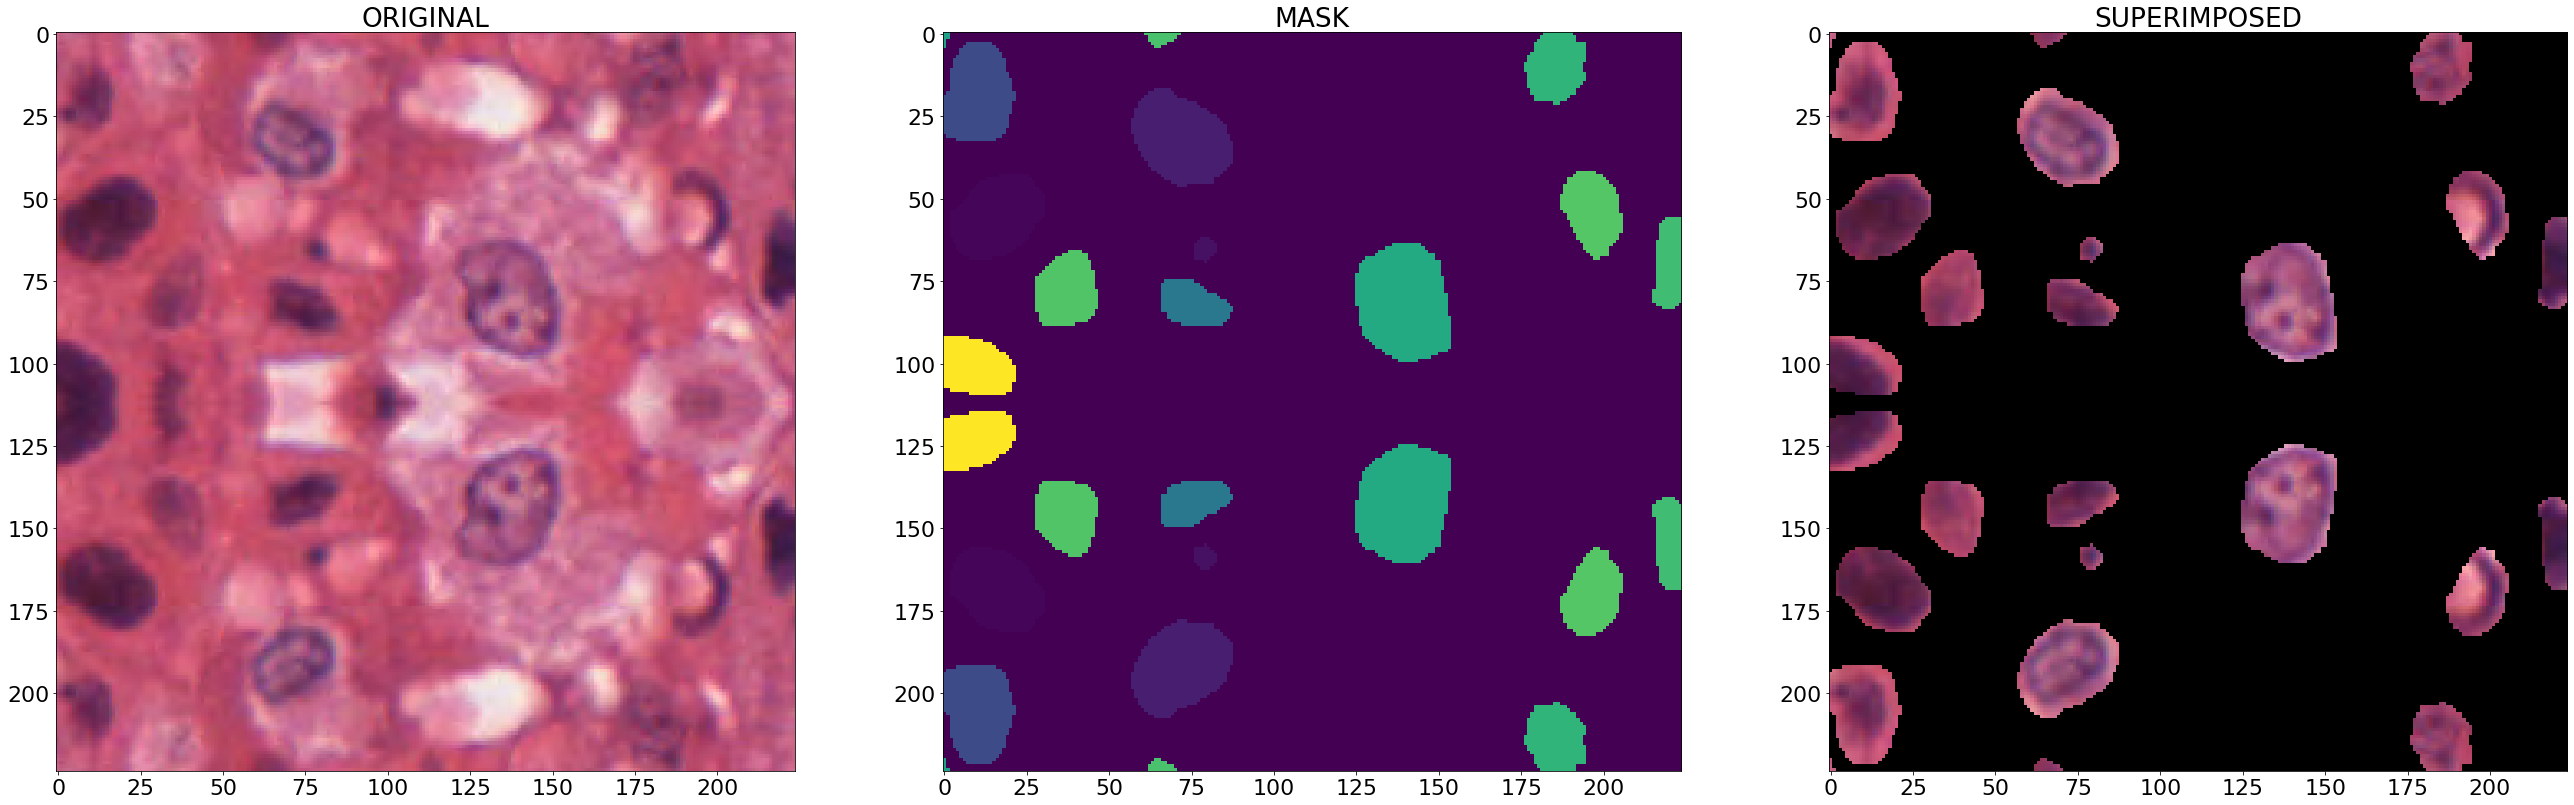

In [15]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
index = 5

with tables.open_file("/home/leos/IMAGE_ANALYSIS/HDF5_data/databases/Kumar/patch_224/train_Kumar.pytable",'r') as db:
    img = db.root.img
    maskd = db.root.mask
    im = img[index,:,:,:]
    mask = maskd[index,:,:]
    

image_overlayed = np.where(mask[..., None], im, 0)
fig, ax = plt.subplots(1,3, figsize=(45,45))
ax[0].imshow(im)
ax[1].imshow(mask)
ax[2].imshow(image_overlayed)
ax[0].title.set_text("ORIGINAL")
ax[1].title.set_text("MASK")
ax[2].title.set_text("SUPERIMPOSED")

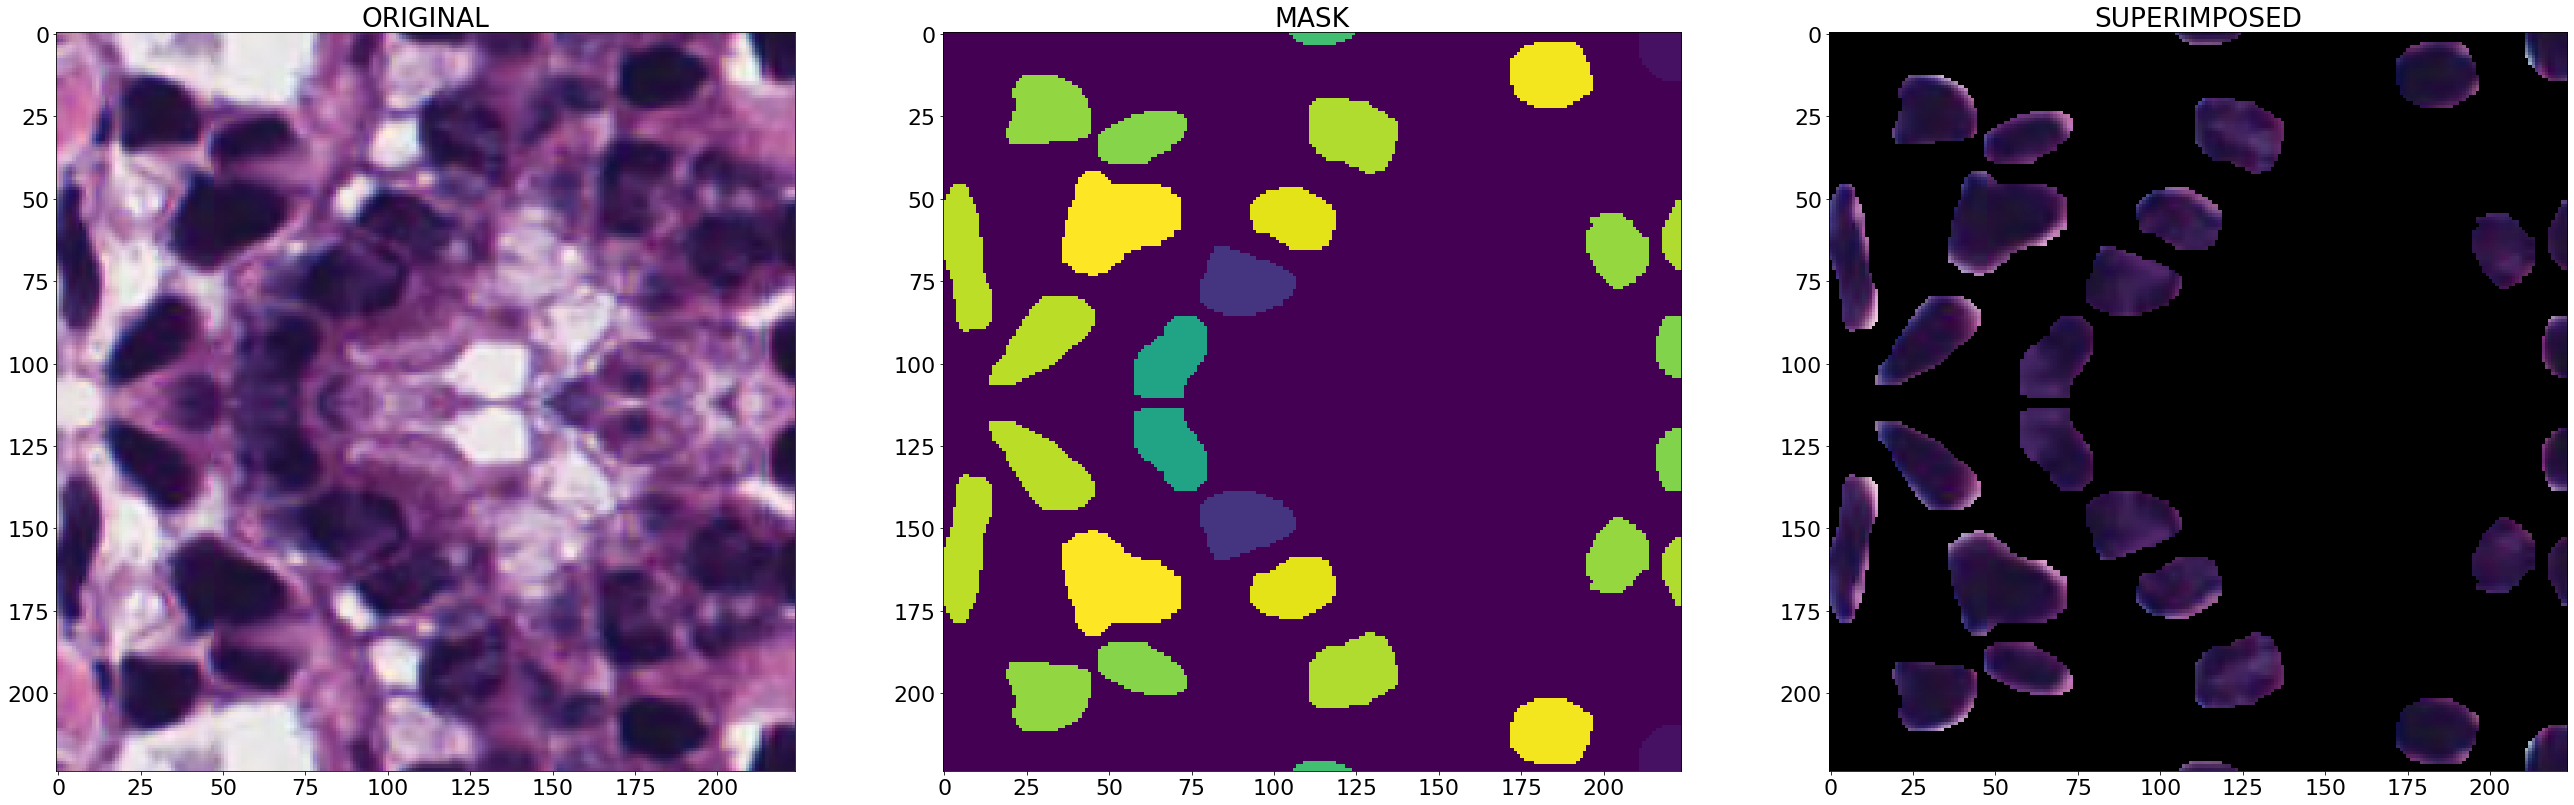

In [16]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
index = 7

with tables.open_file("/home/leos/IMAGE_ANALYSIS/HDF5_data/databases/Kumar/patch_224/test_Kumar.pytable",'r') as db:
    img = db.root.img
    maskd = db.root.mask
    im = img[index,:,:,:]
    mask = maskd[index,:,:]
    

image_overlayed = np.where(mask[..., None], im, 0)
fig, ax = plt.subplots(1,3, figsize=(45,45))
ax[0].imshow(im)
ax[1].imshow(mask)
ax[2].imshow(image_overlayed)
ax[0].title.set_text("ORIGINAL")
ax[1].title.set_text("MASK")
ax[2].title.set_text("SUPERIMPOSED")

In [17]:
# %matplotlib inline
# matplotlib.rcParams.update({'font.size': 22})
# index = 3
# 
# with tables.open_file("/home/leos/IMAGE_ANALYSIS/HDF5_data/databases/Kumar/patch_224/valid_Kumar.pytable",'r') as db:
#     img = db.root.img
#     maskd = db.root.mask
#     im = img[index,:,:,:]
#     mask = maskd[index,:,:]
#     
# 
# image_overlayed = np.where(mask[..., None], im, 0)
# fig, ax = plt.subplots(1,3, figsize=(45,45))
# ax[0].imshow(im)
# ax[1].imshow(mask)
# ax[2].imshow(image_overlayed)
# ax[0].title.set_text("ORIGINAL")
# ax[1].title.set_text("MASK")
# ax[2].title.set_text("SUPERIMPOSED")

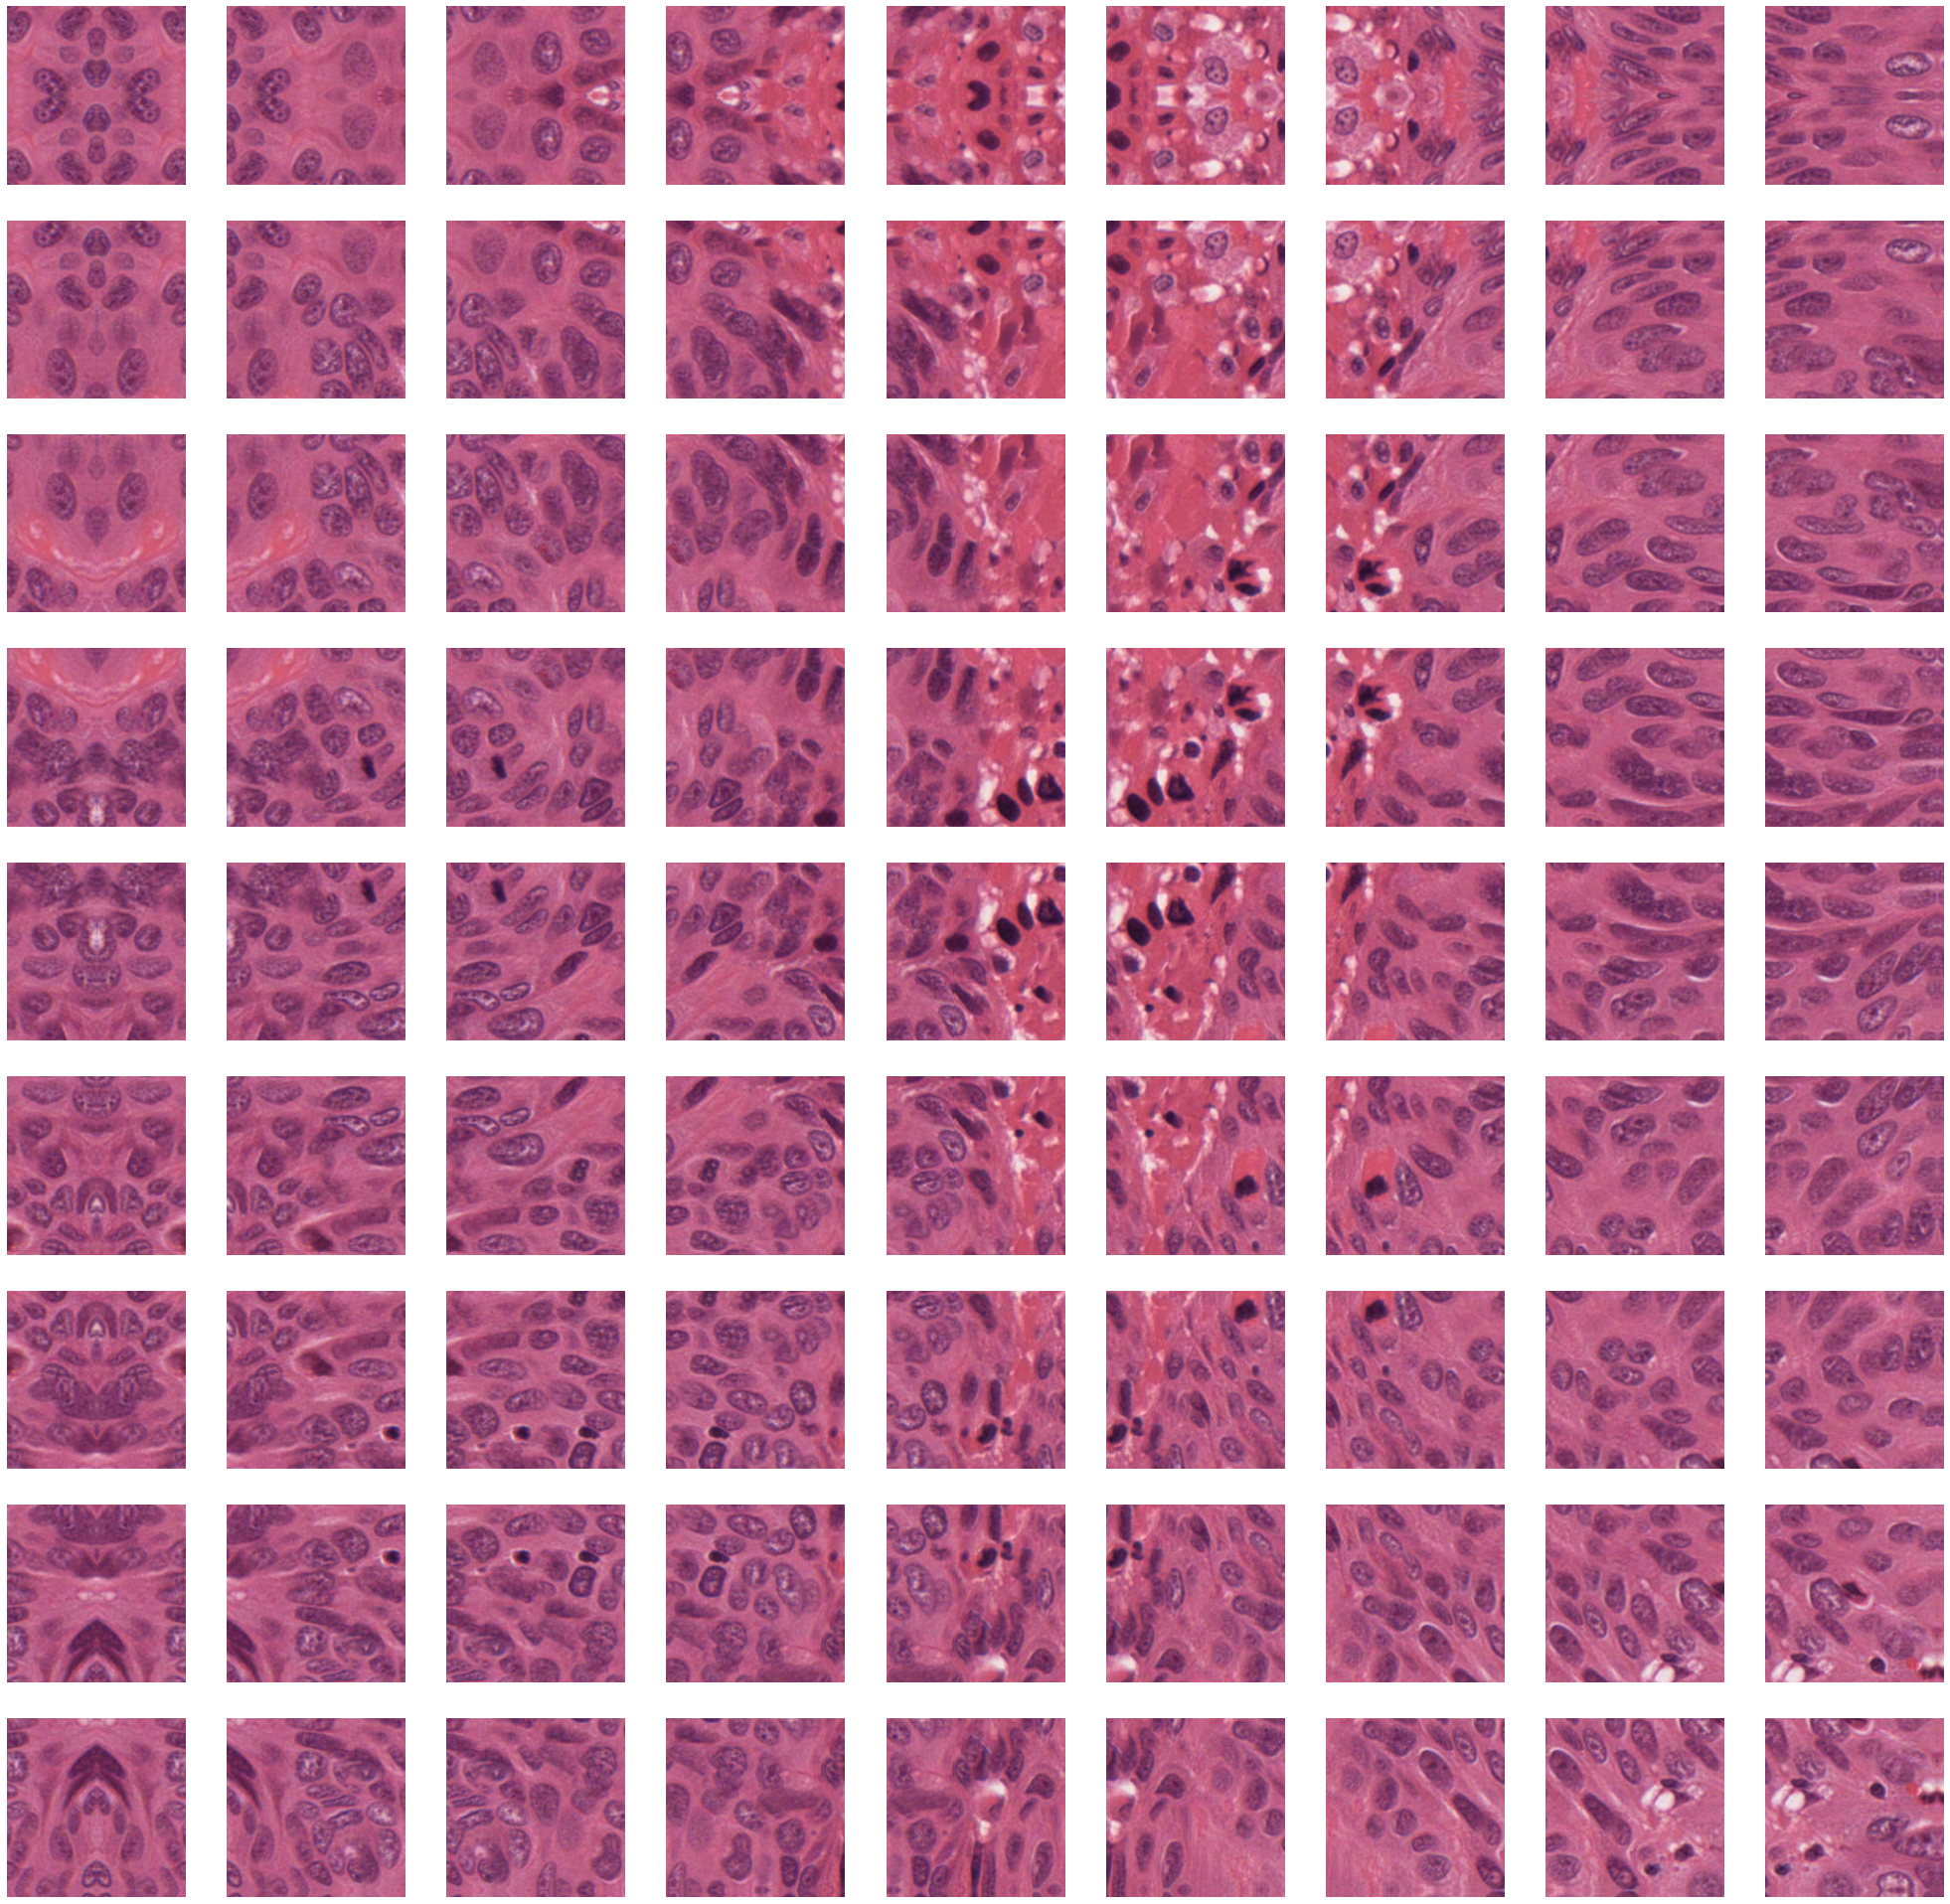

In [18]:
# Visualize one image in patches asnd mirror padding
f = train_imgs[0]
im = cv2.imread(f)
io = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Do mirror padding
io2 = np.pad(
    io,
    [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], 
    mode='reflect'
)

# Extract the patches
io_arr_out = sklearn.feature_extraction.image.extract_patches(
    io2,
    patch_shape=(patch_size, patch_size, 3),
    extraction_step=stride_size
)

# reshape
io_arr_out=io_arr_out.reshape(-1, patch_size,patch_size, 3)
patches = io_arr_out
fignum=200
low=0
high=len(patches)

# Visualize
fig_patches = plt.figure(fignum, figsize=(35,35))
pmin, pmax = patches.min(), patches.max()
dims = np.ceil(np.sqrt(high - low))
for idx in range(high - low):
    spl = plt.subplot(dims, dims, idx + 1)
    ax = plt.axis('off')
    imm = plt.imshow(patches[idx], cmap=matplotlib.cm.gray)
    cl = plt.clim(pmin, pmax)
plt.show()

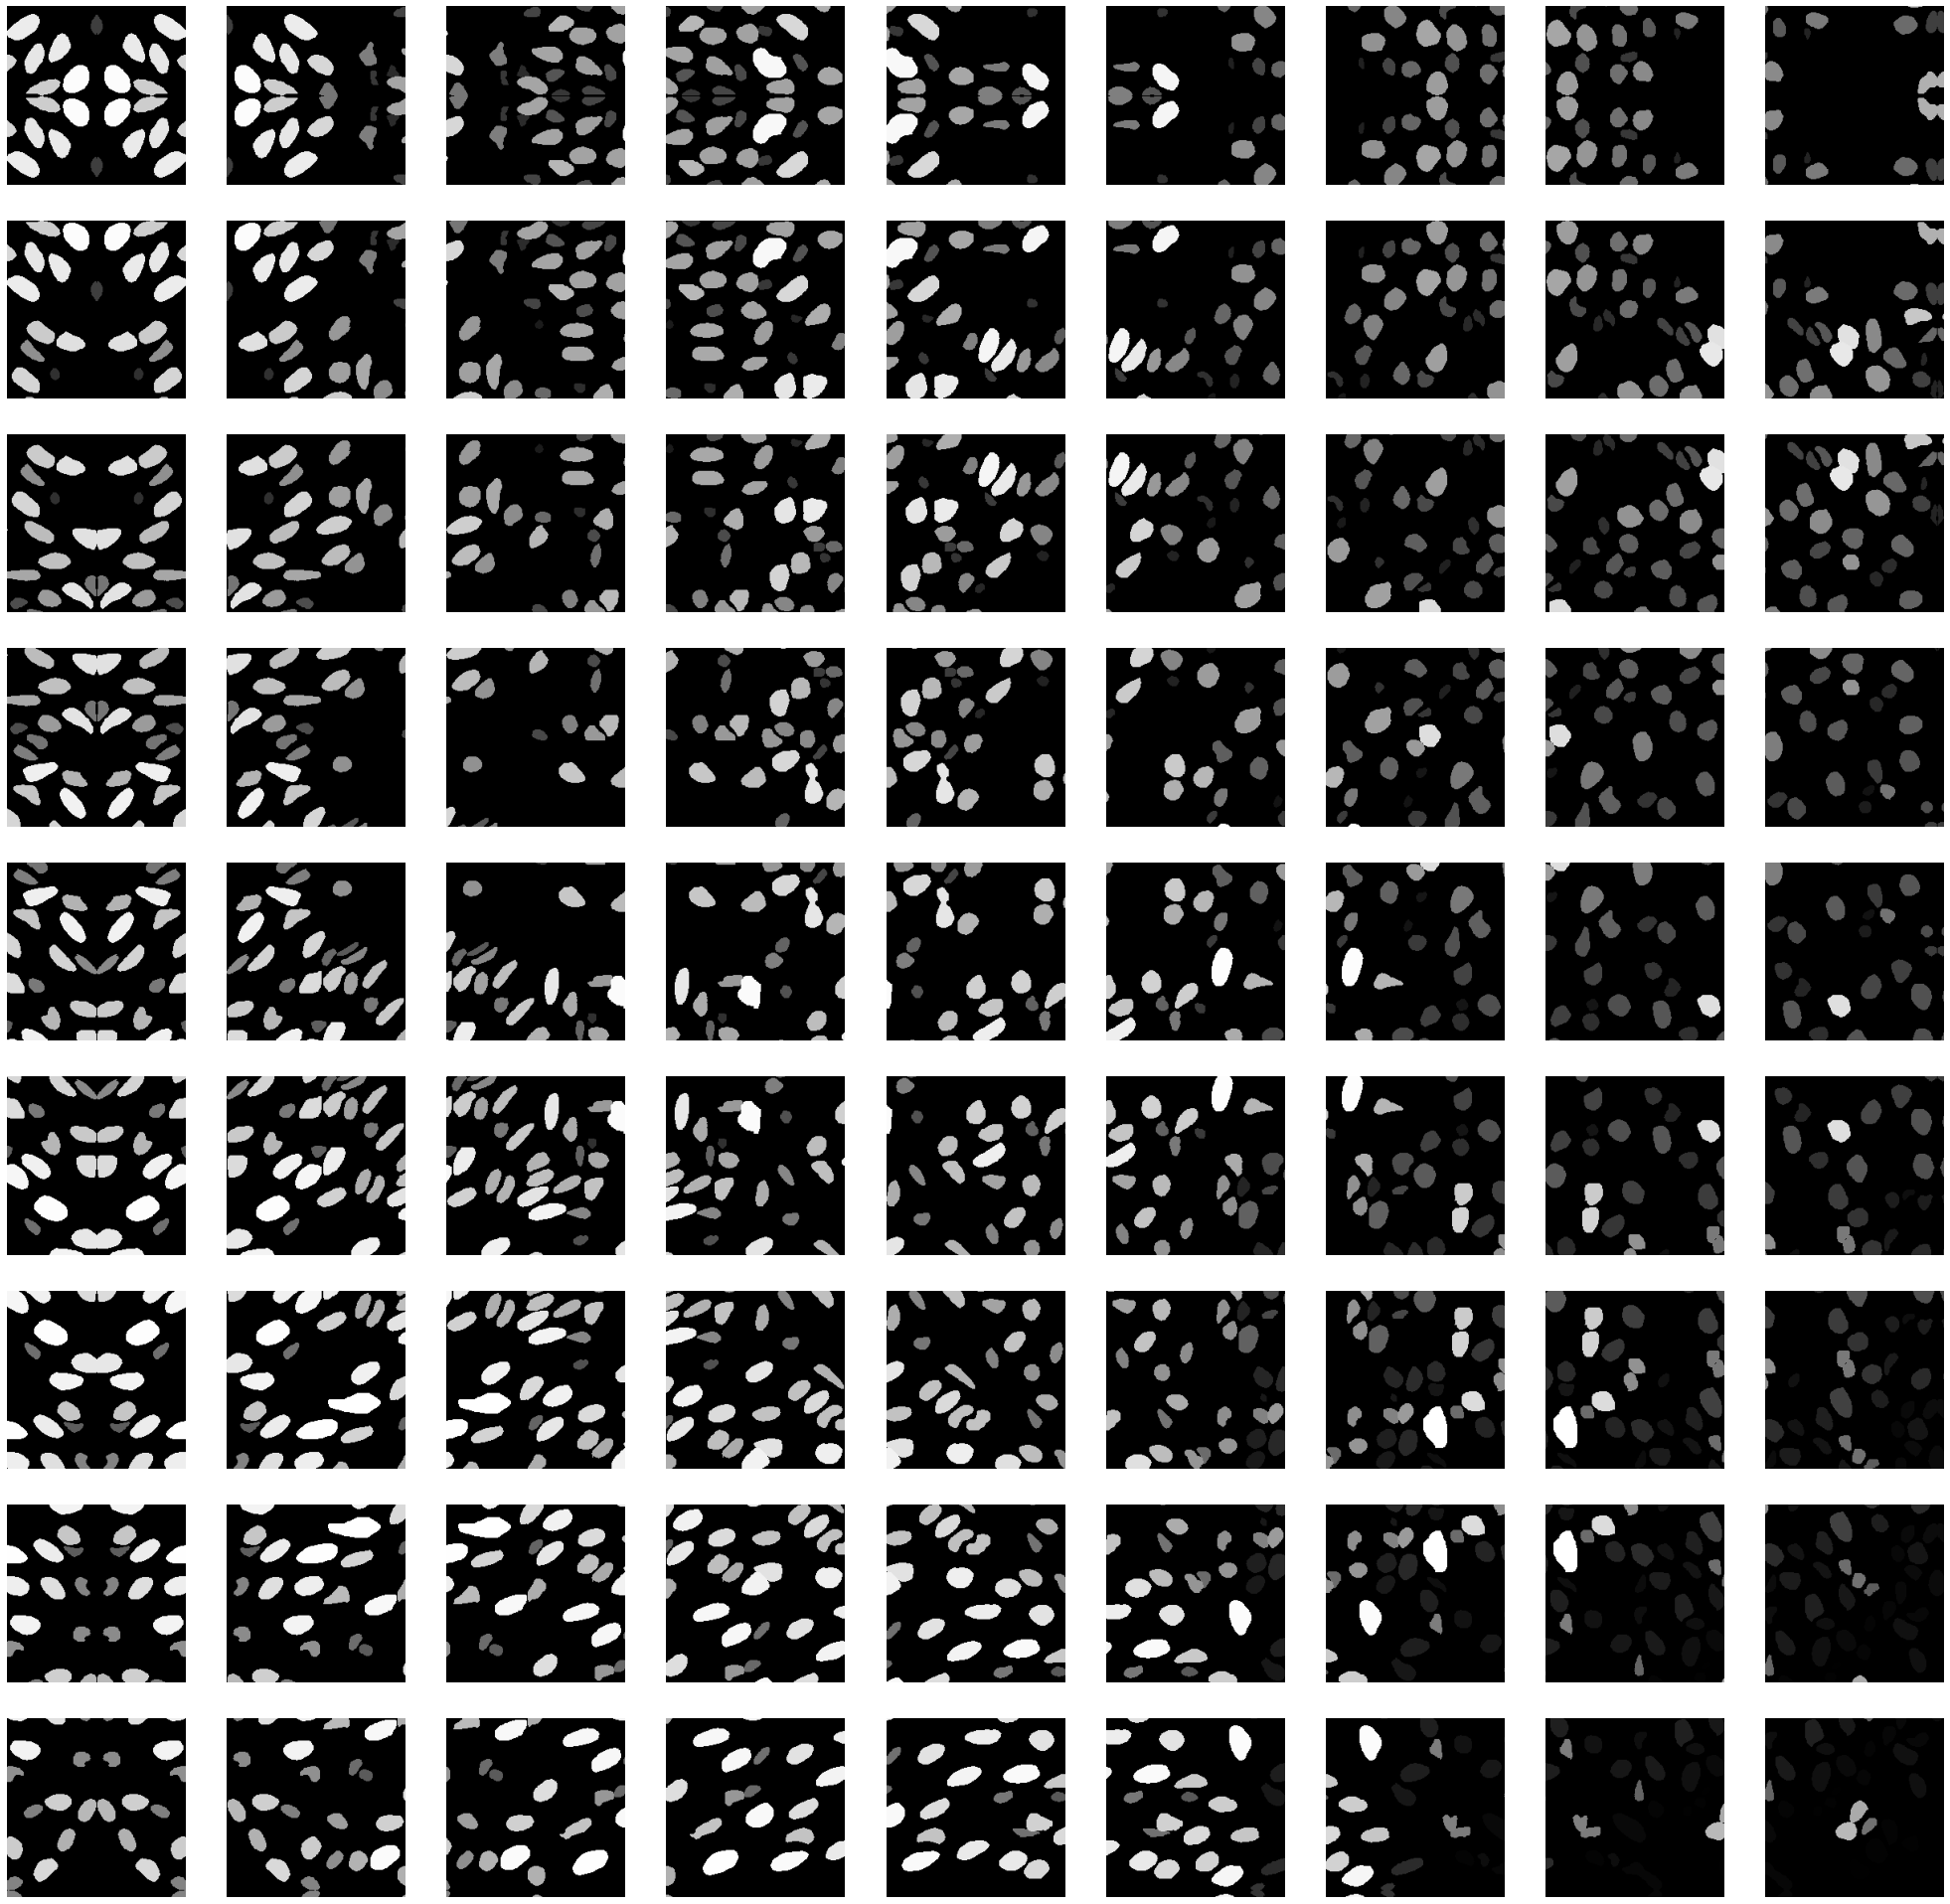

In [19]:
# Visualize one set of labels in patches asnd mirror padding
f = train_masks[0]
io = scipy.io.loadmat(file)
io = io['inst_map']

# Do mirror padding
io2 = np.pad(
    io,
    [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size)], 
    mode='reflect'
)

# Extract the patches
io_arr_out = sklearn.feature_extraction.image.extract_patches(
    io2,
    patch_shape=(patch_size, patch_size),
    extraction_step=stride_size
)

# reshape
io_arr_out=io_arr_out.reshape(-1,patch_size,patch_size)
patches = io_arr_out
fignum=200
low=0
high=len(patches)

# Visualize
fig_patches = plt.figure(fignum, figsize=(35,35))
pmin, pmax = patches.min(), patches.max()
dims = np.ceil(np.sqrt(high - low))
for idx in range(high - low):
    spl = plt.subplot(dims, dims, idx + 1)
    ax = plt.axis('off')
    imm = plt.imshow(patches[idx], cmap=matplotlib.cm.gray)
    cl = plt.clim(pmin, pmax)
plt.show()